# **Individual Assingment**: Default Credit Cards Clients

A bank in you region want to build a model to predict credit card defaulters more accurately in order minimize money loss. For this task we have a set of data on default payments and demographic data to help us do our task. Data is comprised in the following CSV files:


**TRAINING**

**`train_customers.csv`**
 - `ID`: ID of each client
 - `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit
 - `SEX`: Gender (1=male, 2=female)
 - `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
 - `MARRIAGE`: Marital status (1=married, 2=single, 3=others)
 - `AGE`: Age in years
 
**`train_series.csv`**
 - `ID`: ID of each client
 - `MONTH`: The month to wich data is refering
 - `PAY`: Repayment status in the corresponding month (-2=no need to pay, zero balance, -1=pay duly, 0=revolving credit (meaning client paid more than the minimum payment, but less than the total balance), 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
 - `BILL_AMT`: Amount of bill statement in the corresponding month (NT dollar)
 - `PAY_AMT`: Amount of previous payment in the corresponding month (NT dollar)
 
**`train_target.csv`**
 - `DEFAULT_JULY`: Default payment in July (1=yes, 0=no)
 
 
**TEST** (For PART 3)
 - **`test_data.csv`**
 
**SUBMISSION** (For PART 3)
 - **`submission_features.csv`**
 
**BACKUP**
 - **`train_data.csv`**

Load all data and answer the following questions

In [72]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import os
from pandas_profiling import ProfileReport

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold, cross_validate , cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, plot_roc_curve, auc, roc_curve
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## **A. DATA ENGINEERING**

> Load the train_series.csv file and pivot the time-dependent columns (PAY, BILL_AMT, and PAY_AMT) to build one column of these per month. (Ex. PAY_JUNE, PAY_MAY, ..., BILL_AMT_JUNE, ...)

In [4]:
train_series = pd.read_csv('Data/train_series.csv')

In [5]:
train_series.sample(2)

,ID,MONTH,PAY,BILL_AMT,PAY_AMT
23344,7324,FEBRUARY,2.0,101400.0,0.0
29691,3518,MARCH,0.0,36985.0,1000.0


In [6]:
months = list(train_series['MONTH'].unique())
months

['JUNE', 'MAY', 'APRIL', 'MARCH', 'FEBRUARY', 'JANUARY']

In [7]:

for month in months:
    train_series[f'PAY_{month}'] = train_series[train_series['MONTH'] == month]['PAY']
    train_series[f'BILL_AMT_{month}'] = train_series[train_series['MONTH'] == month]['BILL_AMT']
    train_series[f'PAY_AMT_{month}'] = train_series[train_series['MONTH'] == month]['PAY_AMT']

In [8]:
train_series

,ID,MONTH,PAY,BILL_AMT,PAY_AMT,PAY_JUNE,BILL_AMT_JUNE,PAY_AMT_JUNE,PAY_MAY,BILL_AMT_MAY,...,PAY_AMT_APRIL,PAY_MARCH,BILL_AMT_MARCH,PAY_AMT_MARCH,PAY_FEBRUARY,BILL_AMT_FEBRUARY,PAY_AMT_FEBRUARY,PAY_JANUARY,BILL_AMT_JANUARY,PAY_AMT_JANUARY
0,9910,JUNE,0.0,76885.0,3500.0,0.0,76885.0,3500.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9910,MAY,0.0,79106.0,4000.0,NaN,NaN,NaN,0.0,79106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9910,APRIL,0.0,81231.0,3000.0,NaN,NaN,NaN,NaN,NaN,...,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9910,MARCH,0.0,81983.0,3146.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,81983.0,3146.0,NaN,NaN,NaN,NaN,NaN,NaN
4,9910,FEBRUARY,0.0,83773.0,3260.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,83773.0,3260.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,19966,MAY,2.0,22083.0,5.0,NaN,NaN,NaN,2.0,22083.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119996,19966,APRIL,2.0,15444.0,1000.0,NaN,NaN,NaN,NaN,NaN,...,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119997,19966,MARCH,0.0,13695.0,5000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,13695.0,5000.0,NaN,NaN,NaN,NaN,NaN,NaN
119998,19966,FEBRUARY,0.0,17598.0,1000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,17598.0,1000.0,NaN,NaN,NaN


In [9]:
train_series.drop(['MONTH','PAY','BILL_AMT','PAY_AMT'], axis = 1, inplace = True)

In [10]:
train_series.bfill(inplace = True)

In [11]:
train_series.drop_duplicates('ID', keep='first',inplace=True, ignore_index= True)

In [12]:
train_series = train_series[['ID', 'PAY_JUNE','PAY_MAY','PAY_APRIL','PAY_MARCH','PAY_FEBRUARY','PAY_JANUARY',
                   'BILL_AMT_JUNE','BILL_AMT_MAY','BILL_AMT_APRIL','BILL_AMT_MARCH','BILL_AMT_FEBRUARY','BILL_AMT_JANUARY',
                  'PAY_AMT_JUNE','PAY_AMT_MAY','PAY_AMT_APRIL','PAY_AMT_MARCH','PAY_AMT_FEBRUARY','PAY_AMT_JANUARY']] # Rearranging columns

In [13]:
train_series

,ID,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,PAY_FEBRUARY,PAY_JANUARY,BILL_AMT_JUNE,BILL_AMT_MAY,BILL_AMT_APRIL,BILL_AMT_MARCH,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_MARCH,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY
0,9910,0.0,0.0,0.0,0.0,0.0,0.0,76885.0,79106.0,81231.0,81983.0,83773.0,85532.0,3500.0,4000.0,3000.0,3146.0,3260.0,3200.0
1,15561,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4823.0,5471.0,8422.0,4377.0,3910.0,2431.0,5491.0,9683.0,4377.0,3918.0,2431.0,2120.0
2,23607,0.0,0.0,2.0,0.0,0.0,0.0,243621.0,259517.0,253863.0,257535.0,262753.0,268145.0,21400.0,0.0,9400.0,9542.0,9766.0,9786.0
3,6314,0.0,0.0,0.0,0.0,0.0,0.0,29832.0,18628.0,15069.0,15761.0,5879.0,-2879.0,1538.0,1308.0,1000.0,118.0,1329.0,41378.0
4,27534,-2.0,-2.0,-1.0,-1.0,-1.0,-1.0,4500.0,2580.0,178.0,1500.0,0.0,1118.0,2580.0,178.0,1500.0,0.0,1118.0,1331.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,28636,1.0,-2.0,-2.0,-1.0,2.0,2.0,-200.0,-200.0,-200.0,150.0,150.0,350.0,0.0,0.0,350.0,0.0,200.0,0.0
19996,17730,0.0,0.0,0.0,0.0,0.0,0.0,59236.0,53689.0,48551.0,34656.0,18077.0,18815.0,2000.0,2124.0,2047.0,5618.0,1000.0,2000.0
19997,28030,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,3339.0,13047.0,7764.0,623.0,4695.0,4133.0,10000.0,7764.0,623.0,4695.0,5973.0,4421.0
19998,15725,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-7.0,1765.0,5074.0,19268.0,5606.0,2534.0,1772.0,5099.0,19364.0,5634.0,2547.0,33300.0


> Load train_customers.csv and include the pivoted table of time series data. The resulting table must be a table with one row per customer (ID)

In [14]:
train_customers = pd.read_csv('Data/train_customers.csv')
train_customers.sample(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
18514,12791,390000.0,2,2,2,28
3560,5961,60000.0,2,2,2,24
14247,18853,10000.0,1,2,1,33


In [15]:
train_customers['ID'].nunique()

20000

In [16]:
train_macrotable = train_customers.merge(train_series, how= 'right', on= 'ID')

In [17]:
train_macrotable['ID'].nunique()

20000

Include information from the target (train_target.csv) on the table

surnamename_A_train.csv - This is the resulting CSV after applying all transformations exposed in questions A.1, A.2 and A.3.

In [18]:
train_target = pd.read_csv("Data/train_target.csv")
train_target.sample(2)

,ID,DEFAULT_JULY
11548,7834,0
2104,9065,0


In [19]:
train_macrotable = train_macrotable.merge(train_target, how= 'right', on= 'ID')

In [20]:
train_macrotable.sample(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,...,BILL_AMT_MARCH,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_MARCH,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,DEFAULT_JULY
15089,22621,170000.0,1,2,1,30,-1.0,-1.0,-1.0,0.0,...,416.0,416.0,566.0,832.0,632.0,200.0,416.0,566.0,416.0,0
5917,12103,80000.0,1,2,1,45,0.0,0.0,0.0,0.0,...,38419.0,39316.0,35902.0,1600.0,2000.0,1703.0,1600.0,1400.0,10350.0,0
8000,1150,260000.0,1,2,1,42,0.0,0.0,0.0,0.0,...,255079.0,208755.0,196701.0,10030.0,10000.0,65500.0,10000.0,8000.0,10000.0,0


In [22]:
train_macrotable.to_csv('Submissions/vanmeijelniels_A_train.csv')

## **B. EXPLORATORY DATA ANALYSIS**

BAR PLOT: Plot the distribution of defaulters given the Education. Comment the results.

In [23]:
q1_df = train_macrotable[train_macrotable['DEFAULT_JULY'] == 1][['ID','EDUCATION','DEFAULT_JULY']]

In [24]:
q1_df['EDUCATION'].unique()

array([3, 1, 2, 5, 4, 6], dtype=int64)

In [25]:
education_map = {
    1: 'graduate school', 
    2: 'university' , 
    3 : 'high school', 
    4: 'others', 
    5: 'unknown',
    6:'unknown'
}

In [26]:
q1_df.loc[:,'EDUCATION'] = q1_df['EDUCATION'].map(education_map)

In [27]:
q1_df_gby = q1_df.groupby('EDUCATION').count().reset_index().sort_values('DEFAULT_JULY', ascending=False)
q1_df_gby

,EDUCATION,ID,DEFAULT_JULY
3,university,2225,2225
0,graduate school,1336,1336
1,high school,836,836
4,unknown,17,17
2,others,6,6


In [38]:
fig = go.Figure(
    data=[go.Bar(x=q1_df_gby.EDUCATION, y=q1_df_gby.DEFAULT_JULY, marker_color='indianred')],
    layout=go.Layout(title='Number of Defaults per Education Level', 
                     template='plotly_dark'))
fig.update_layout(yaxis=dict(title='Count') )
fig.show()

In [43]:
#BOX PLOT - Plot the distribution of `LIMIT_BAL` per defaulters and non-defaulters.

fig = go.Figure(
    data=[go.Box(y=train_macrotable.DEFAULT_JULY, x=train_macrotable.LIMIT_BAL, orientation='h', marker_color='indianred')],
    layout=go.Layout(title="Limit Balance for Defaulters and Non-defaulters",
                        template='plotly_dark'))
fig.update_layout( yaxis=dict(title='Limit Balance'))
fig.show()


Include 3 more interesting insights extracted from the data. Provide an explanation of the choices made and the results obtained.

In [79]:
os.makedirs("../profiling", exist_ok=True)
ProfileReport(train_macrotable).to_file(f"train_macrotable.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Profiling Report was not as useful as initially expected, better yet try to understand the data.
# We can extract insights about customers that have payment delays. 
# We can look at the total number of clients that has payment delay every number

### Insght 1

In [46]:
# The amount of customers in the dataset that had a payment deylay of a month or more (as a mask)
train_macrotable.loc[:,'PAY_JUNE':'PAY_JANUARY' ][train_macrotable.loc[:,'PAY_JUNE':'PAY_JANUARY'] >= 1].count() 

PAY_JUNE        4512
PAY_MAY         2937
PAY_APRIL       2800
PAY_MARCH       2299
PAY_FEBRUARY    1944
PAY_JANUARY     2049
dtype: int64

In [47]:
fig = go.Figure(
    data=[go.Bar(x=train_macrotable.loc[:,'PAY_JUNE':'PAY_JANUARY' ].columns, y=train_macrotable.loc[:,'PAY_JUNE':'PAY_JANUARY' ][train_macrotable.loc[:,'PAY_JUNE':'PAY_JANUARY' ] >= 1].count(), marker_color='indianred')],
    layout=go.Layout(title='Number of Customers with Payment Delay per Month',
                        template='plotly_dark'))
fig.update_layout(yaxis=dict(title='Count'), xaxis=dict(title='Month'))
fig.show()

> The table above shows the number of clients with payment delay greater or eaqual to 1 in each separate month. The number of delayed payments is increasing over time. arguably it can be said that customers with payment delays in january forexample may naturally have payment delay -1 in the consecutive month. However this is not strictly the case, revision of the data shows that some clients may have payment delay of 5 months in january to 2 months in february. Further investigation would require looking into the sums billed and paid in each month. 

> Never the less, it is likely that customers who have payment delay greater or equal to one month and are still given credit are likely to have the same problems or worse in the consecutive month. Its easier for customers to delay payment for a month or more than it is to pay back a delayed fee plus a current months billed amount. It is expected therefore that throughout the upcoming months the count of customers with payment delay greater or equal to one month will increase. It would be wise to reconsider the basis on which credit is issued.


> The following insihgts are pie charts looking more closely at demographic profiles of customers that had a payment delay of one month or greater in ANY of the months January through June. 

In [56]:
# Data Frame with customers that had a payment delay of one or more periods in any month June through Januray
delayed_clients = train_macrotable[(train_macrotable.loc[:,'PAY_JUNE':'PAY_JANUARY'] >= 1).any(axis=1)]

In [57]:
demographic_cols = ['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
delay_client_demo = delayed_clients[demographic_cols]
delay_client_demo.sample(3)

,ID,SEX,EDUCATION,MARRIAGE,AGE
10192,16324,2,2,2,28
13949,8783,2,2,1,35
6197,2730,2,2,2,28


In [58]:
education_map = {
    0: 'unknown',
    1: 'graduate school', 
    2: 'university' , 
    3 : 'high school', 
    4: 'others', 
    5: 'unknown',
    6:'unknown'
}

In [59]:
gender_map = {
    1: 'male',
    2: 'female',
}

In [60]:
marriage_map = {
    0: 'unknown',
    1: 'married',
    2: 'single',
    3: 'others',
}

In [62]:
delay_client_demo.loc[:, 'SEX'] = delay_client_demo['SEX'].replace(gender_map)
delay_client_demo.loc[:, 'EDUCATION'] = delay_client_demo['EDUCATION'].replace(education_map)
delay_client_demo.loc[:, 'MARRIAGE'] = delay_client_demo['MARRIAGE'].replace(marriage_map)

C:\Users\niels\AppData\Local\Temp\ipykernel_25244\1415027512.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\niels\AppData\Local\Temp\ipykernel_25244\1415027512.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\niels\AppData\Local\Temp\ipykernel_25244\1415027512.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [63]:
delay_client_demo.sample(3)

,ID,SEX,EDUCATION,MARRIAGE,AGE
3944,3748,female,university,single,23
6221,14348,male,graduate school,married,58
4062,8138,female,university,single,48


### Insight 2

In [66]:

education_counts = delay_client_demo.groupby('EDUCATION').size().reset_index(name='Count')

fig = go.Figure(data=go.Pie(
    labels=education_counts['EDUCATION'],
    values=education_counts['Count']), 
    layout=go.Layout(title='Education Level of Customers with Payment Delay',
                        template='plotly_dark',
                        width=800,
                        height=600))

fig.show()

> Much as the insights from Q1 showed, the majority of defaulters and in this case the share of clients that ever had any payment delay, consists of university graduates (48.1%). It is evident that cleints with the two highest levels of education (graduate school and university) represent the majority (80.2%) of clients that ever had any payment delays on their credit. Looking more closely at the distribution of these two levels of education amongst all clients revealed that they do infact make up the greatest share of the clientele in the dataset in the first place (university 46.5%, graduate school 35.4%, see hidden cell below). More intrestingly however is the highschool class which in the entire dataset represented 16.5% whilst they represented 19.1% in the dataframe filtered for clients with any payment delays. 

### Insight 3

In [69]:
gender_delayed

,SEX,ID,EDUCATION,MARRIAGE,AGE
0,female,3907,3907,3907,3907
1,male,2768,2768,2768,2768


In [70]:
gender_delayed = delay_client_demo.groupby('SEX').count().reset_index()

fig = go.Figure(data=go.Pie(
    labels=gender_delayed['SEX'],
    values=gender_delayed['ID']), 
    layout=go.Layout(title='Sex of Customers with any Payment Delay',
                        template='plotly_dark',
                        width=800,
                        height=600))

fig.show()


> Similarly i looked at the SEX category and did a group by to count each category. Amongst the the customers that ever had any payment delay females represented 58.5% and males 41.5% of the dataset. This compared to 60.6% females and 39.4% males in the entire data set (see hidden cell for entire dataset). Considering that the share of woemn represented in the query is smaller one could also assume that a women makes a more reliable credit holder who may be more likely to never use credit or pay back her loan duly (atleast the minimal amount).

### Insight 4

In [71]:
marriage_delayed = delay_client_demo.groupby('MARRIAGE').count().reset_index()

fig = go.Figure(data=go.Pie(
    labels=marriage_delayed['MARRIAGE'],
    values=marriage_delayed['ID']),
    layout=go.Layout(title='Marriage Status of Customers with any Payment Delay',
                        template='plotly_dark',
                        width=800,
                        height=600))

fig.show()

> Lastly i looked at the last demographic column amongst customers filtered for the same query: where they had a payment delay of one month or greater in any of the columns representing the months. The share of customers in different marrital categories with payment delays is represented almost identically as they are in the entire dataset (only 0.2% difference). We can therefore assume that this category will of little importance to a clients ability to repay credit duly

## **C. MACHINE LEARNING**

### Build the model

In [73]:
features_df = train_macrotable.drop('DEFAULT_JULY', axis = 1)
target = train_macrotable['DEFAULT_JULY']

#### Standardizing data

In [75]:
std_data = features_df #lets cast a copy in case

#Exclude /include certain columns
exclude_cols = ['ID', 'SEX', 'EDUCATION', 'MARRIAGE'] # Exclude the categorical columns from standardization
cols_to_scale = [col for col in features_df.columns if col not in exclude_cols]

std_scaler = StandardScaler() #initiate

std_data[cols_to_scale] = std_scaler.fit_transform(std_data[cols_to_scale]) # apply scaler

std_data.sample(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,...,BILL_AMT_APRIL,BILL_AMT_MARCH,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_MARCH,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY
10974,3629,0.246909,2,3,2,0.704805,0.907328,-0.724271,-0.696803,-0.664849,...,-0.642046,-0.732511,-0.466327,-0.453569,0.251951,-0.144441,-0.285565,1.179624,-0.309493,1.341782
8011,14779,-0.908837,2,2,1,0.813141,0.015605,0.112601,1.810132,1.910588,...,-0.371618,-0.354272,-0.315169,-0.288642,-0.161319,-0.166317,-0.285565,-0.241102,-0.245372,-0.248553
13873,17086,2.558401,2,1,2,0.271459,0.015605,0.112601,0.138842,0.193630,...,0.309397,0.414642,0.487082,0.492948,-0.101690,0.036533,-0.017991,0.005981,-0.053011,-0.003886


# Machine Learning Models
> Standardized data will be passed through Logistic Regression, XGBoost and Random Forest ML Models. The metric used to evaluate the model is the roc_auc.

In [76]:
# Cross Validation Settings. 
randstate = 12
kfolds = 10

In [77]:
# Cross validattion settings

kf = KFold(n_splits=kfolds, shuffle=True, random_state=randstate)
scoring = ["precision", "recall", "f1", "accuracy", "roc_auc"]

### LOGISTIC REGRESSION

In [78]:
# Build a Logistic Regression Model on the train data
logreg = LogisticRegression(C=0.56, max_iter =200)
logreg.fit(std_data, target)

LogisticRegression(C=0.56, max_iter=200)

In [444]:
grid_param = {
    'C' : [0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59,0.6]
}

In [445]:
clf = GridSearchCV(logreg, grid_param, n_jobs=-2)
clf.fit(std_data, target)
clf.best_estimator_

LogisticRegression(C=0.56, max_iter=200)

### XG BOOST 

In [542]:
xgboost = XGBClassifier(booster= 'gbtree', n_estimators=31, max_depth=2, gamma= 5, reg_alpha= 4, reg_lambda= 6, colsample_bytree= 0.5, subsample= 0.65)
xgboost.fit(std_data, target)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=31, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [807]:
grid_param = {
    #'n_estimators' : list(range(21,40)),
    #'max_depth' : list(range(1,4)),
    #'max_leaves': list(range(0,10)),
    #'subsample' : [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.90, 0.95, 0.99 ],
    #'colsample_bytree': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.90, 0.95, 0.99 ],
    #'reg_alpha' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #'reg_lambda': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #'gamma': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #'min_child_weight': [2, 4, 6, 8]
}

In [553]:
clf = GridSearchCV(xgboost, grid_param, n_jobs=-1)
clf.fit(std_data, target)
clf.best_estimator_

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=31, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [554]:
best_params = clf.best_params_
best_params

{'max_leaves': 0}

### DECISION TREE

In [379]:
dec_tree = DecisionTreeClassifier(random_state= randstate, max_depth=2, max_leaf_nodes=4, min_samples_leaf=2)
dec_tree.fit(std_data, target)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, min_samples_leaf=2,
                       random_state=12)

In [423]:
grid_param = {
    'max_depth' : list(range(1,5)), 
    'max_leaf_nodes' : list(range(2,6)), 
    'min_samples_leaf' : list(range(2,6)),
}

In [424]:
clf = GridSearchCV(dec_tree, grid_param, n_jobs=-1)
clf.fit(std_data, target)

GridSearchCV(estimator=DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4,
                                              min_samples_leaf=2,
                                              random_state=12),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'max_leaf_nodes': [2, 3, 4, 5],
                         'min_samples_leaf': [2, 3, 4, 5]})

In [425]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, min_samples_leaf=2,
                       random_state=12)

max_depth: 1, train acc: 0.820, test acc: 0.820
max_depth: 2, train acc: 0.821, test acc: 0.821
max_depth: 3, train acc: 0.823, test acc: 0.820
max_depth: 4, train acc: 0.824, test acc: 0.821
max_depth: 5, train acc: 0.826, test acc: 0.820
max_depth: 6, train acc: 0.829, test acc: 0.818
max_depth: 7, train acc: 0.834, test acc: 0.817
max_depth: 8, train acc: 0.839, test acc: 0.814
max_depth: 9, train acc: 0.847, test acc: 0.810
max_depth: 10, train acc: 0.856, test acc: 0.803
max_depth: 11, train acc: 0.866, test acc: 0.800


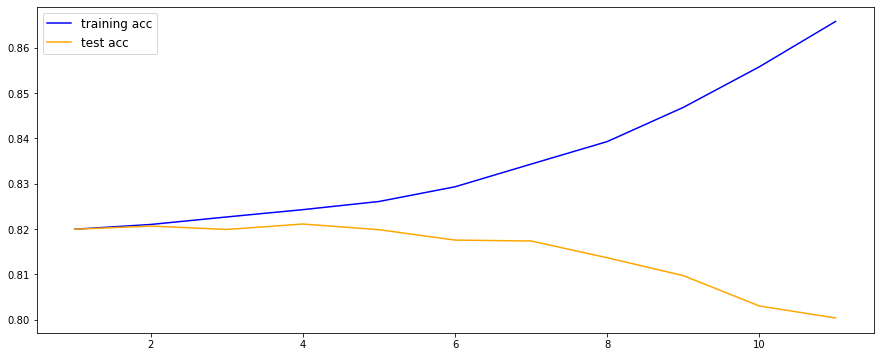

In [344]:
max_depth_range = range(1, 12,)

cv_results = []

# looping through values of max_depth
for max_depth in max_depth_range:
    
    # parameters
    parameters = {
        "max_depth": max_depth, 
        "random_state": randstate
    }

    # train
    dec_tree = DecisionTreeClassifier(**parameters)
    dec_tree.fit(std_data, target)
    
    #Scoring
    
    scores = cross_validate(dec_tree, std_data, target, cv=kfolds, return_train_score=True)
    
    # store results
    cv_results.append({
        "max_depth": max_depth, 
        "train_score": scores["train_score"].mean(),
        "test_score": scores["test_score"].mean()
    })
     
    
    # print evolution of loop:
    print(f"max_depth: {max_depth}, train acc: {scores['train_score'].mean():.3f}, test acc: {scores['test_score'].mean():.3f}")

    
# saving results as dataframe
results = pd.DataFrame(cv_results)

# plotting
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(results["max_depth"], results["train_score"], label="training acc", color="blue")
ax.plot(results["max_depth"], results["test_score"], label="test acc", color="orange")

ax.legend(fontsize=12)

plt.show()

### RANDOM FOREST

In [569]:
rnd_forest = RandomForestClassifier(max_depth=7, n_estimators=123, criterion= 'entropy')
rnd_forest.fit(std_data, target)

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=123)

In [573]:
grid_param = {
    #"n_estimators": list(range(70,130)),
    #"criterion": ["gini", "entropy"],
    #"max_depth": list(range(1,10)),
    #"min_samples_split": [2, 5, 10],
    #"min_samples_leaf": [1, 2, 3, 4],
    #"ccp_alpha": [0.0, 0.1, 0.2,0.3, 0.4, 0.5, 1]
}

In [567]:

clf = GridSearchCV(rnd_forest, grid_param, n_jobs=-1)
clf.fit(std_data, target)
clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=123)

In [ ]:
#max_depth=7, max_features=5, n_estimators=156
#max_depth=8, n_estimators=158

In [568]:
clf.best_params_

{'max_depth': 7, 'n_estimators': 123}

### TRAIN PERFORMANCE CV

In [478]:
# Logreg Model 
logreg_std_scores = cross_validate(logreg, std_data, target, cv=kf, scoring=scoring, return_estimator= True)
lr_mean_auc = logreg_std_scores['test_roc_auc'].mean()
lr_fpr, lr_tpr, _ = roc_curve(target, logreg.predict_proba(std_data)[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [575]:
# XGBoost Model
xgb_scores = cross_validate(xgboost, std_data, target, cv=kf, scoring=scoring, return_estimator= True)
xgb_mean_auc = xgb_scores['test_roc_auc'].mean()
xgb_fpr, xgb_tpr, _ = roc_curve(target, xgboost.predict_proba(std_data)[:,1])
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

In [455]:
# Dec. Tree Model
dect_scores = cross_validate(dec_tree, std_data, target, cv=kf, scoring=scoring, return_estimator= True)
dt__mean_auc = dect_scores['test_roc_auc'].mean()
dt_fpr, dt_tpr, _ = roc_curve(target, dec_tree.predict_proba(std_data)[:,1])
dt_roc_auc = auc(dt_fpr, dt_tpr)

In [570]:
# Rnd Forest Model 
rf_scores = cross_validate(rnd_forest, std_data, target, cv=kf, scoring=scoring, return_estimator= True)
rf_mean_auc = rf_scores['test_roc_auc'].mean()
rf_fpr, rf_tpr, _ = roc_curve(target, rnd_forest.predict_proba(std_data)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)


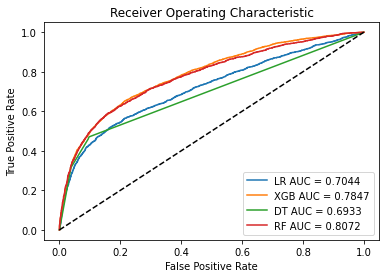

In [576]:
plt.plot(lr_fpr, lr_tpr, label= f'LR AUC = {lr_roc_auc:.4f}') # LogReg
plt.plot(xgb_fpr, xgb_tpr, label= f'XGB AUC = {xgb_roc_auc:.4f}') # XGBoost
plt.plot(dt_fpr, dt_tpr, label= f'DT AUC = {dt_roc_auc:.4f}') # Decision Tree
plt.plot(rf_fpr, rf_tpr, label= f'RF AUC = {rf_roc_auc:.4f}') # Random Forest

plt.plot([0, 1], [0, 1], 'k--') # Professors Dumb Model

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

## TEST PERFORMANCE

In [400]:
test_data = pd.read_csv('test_data.csv')
X_test = test_data.drop('DEFAULT_JULY', axis= 1)
y_test = test_data['DEFAULT_JULY']

In [813]:
# Copy the DF
X_std_test = X_test

#Exclude certain columns
exclude_cols = ['ID', 'SEX', 'EDUCATION', 'MARRIAGE'] # Exclude the categorical columns from standardization

# Initiate the standard scaler
std_scaler = StandardScaler()

# Make a list with columns that will be standardized
cols_to_scale = [col for col in X_test.columns if col not in exclude_cols]

# Apply the scaler to the relevant columns
X_std_test[cols_to_scale] = std_scaler.fit_transform(X_std_test[cols_to_scale])

X_std_test.sample(1)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,...,BILL_AMT_APRIL,BILL_AMT_MARCH,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_MARCH,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY
5910,21708,-1.12931,2,1,2,-1.458858,0.016096,0.111754,0.139325,0.178655,...,-0.408794,-0.394663,-0.46165,-0.490649,-0.221147,-0.200663,-0.236086,-0.253185,-0.296534,-0.196065


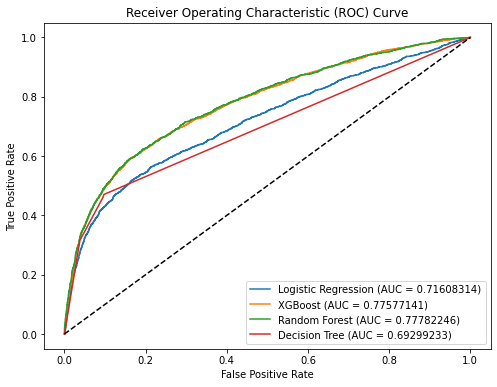

In [814]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, logreg.predict_proba(X_std_test)[:,1])
lr_auc = auc(lr_fpr, lr_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgboost.predict_proba(X_std_test)[:,1])
xgb_auc = auc(xgb_fpr, xgb_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rnd_forest.predict_proba(X_std_test)[:,1])
rf_auc = auc(rf_fpr, rf_tpr)

dt_fpr, dt_tpr, _ = roc_curve(y_test, dec_tree.predict_proba(X_std_test)[:,1])
dt_auc = auc(dt_fpr, dt_tpr)

plt.figure(figsize=(8, 6))

plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.8f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.8f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.8f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.8f})')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.show()


##  🏆Winning Model🏆

In [812]:
rnd_forest

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=123)

In [578]:
submi_data = pd.read_csv("submission_features.csv")

exclude_cols = ['ID', 'SEX', 'EDUCATION', 'MARRIAGE'] 
cols_to_scale = [col for col in submi_data.columns if col not in exclude_cols]

std_scaler = StandardScaler()

submi_data[cols_to_scale] = std_scaler.fit_transform(submi_data[cols_to_scale])

submi_data.sample(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_JUNE,PAY_MAY,PAY_APRIL,PAY_MARCH,...,BILL_AMT_APRIL,BILL_AMT_MARCH,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MAY,PAY_AMT_APRIL,PAY_AMT_MARCH,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY
498,17560,-0.909357,1,1,2,0.124403,-0.010367,0.094601,0.135152,0.183071,...,-0.177105,-0.216511,-0.182129,-0.166666,-0.263564,-0.267648,-0.275834,-0.240969,-0.234059,-0.249889
729,11659,0.084328,1,2,2,-1.084457,-0.010367,0.094601,0.135152,0.183071,...,0.184386,0.265852,0.352234,0.409451,-0.048869,-0.124007,-0.064811,-0.053841,-0.054145,-0.069260
299,16613,-1.215106,2,3,2,1.662952,-0.010367,0.094601,0.135152,0.183071,...,-0.643379,-0.581697,-0.602524,-0.699560,-0.250124,-0.300905,-0.176661,-0.300253,-0.298262,-0.311878


In [584]:
rnd_forest

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=123)

In [580]:
pred = rnd_forest.predict_proba(submi_data)[:,1]

array([0.18407376, 0.42214424, 0.35216949, 0.18907896, 0.13171645,
       0.2633149 , 0.18360136, 0.11733226, 0.16137704, 0.10278721,
       0.80222085, 0.19782791, 0.30688878, 0.60834701, 0.25563852,
       0.07884641, 0.11758871, 0.13761512, 0.0907992 , 0.15518107,
       0.09874818, 0.1067674 , 0.08029814, 0.09325183, 0.13813557,
       0.13453318, 0.20909579, 0.41832574, 0.21740859, 0.09465008,
       0.29139719, 0.19042738, 0.6702698 , 0.22822861, 0.1089249 ,
       0.21240817, 0.75229764, 0.5756711 , 0.13728795, 0.12206441,
       0.16832245, 0.13189179, 0.19576499, 0.53691738, 0.39993014,
       0.31590904, 0.18842369, 0.0840191 , 0.11033486, 0.15832629,
       0.66839195, 0.52787739, 0.18902381, 0.14790455, 0.39986356,
       0.18501371, 0.33899223, 0.25545706, 0.15147336, 0.11788589,
       0.09308804, 0.19614458, 0.14845539, 0.24869085, 0.24138337,
       0.17575365, 0.12599262, 0.17315773, 0.07640164, 0.65410318,
       0.15215665, 0.16400501, 0.12818049, 0.19541892, 0.22026

In [737]:
# Create output dataframe
submi_df = pd.DataFrame({
    'ID': submi_data['ID'],
    'probability': pred
})
submi_df.sample(1)

,ID,probability
564,7200,0.724332


In [595]:
# Save predictions to a CSV file
submi_df.to_csv('Submissions/vanmeijelniels_C1_submission.csv', index=False)

In [596]:
submi_df.shape

(1000, 2)

In [815]:
top5_df = submi_df.sort_values('probability', ascending= True).head(5)
top5_df

,ID,probability
185,9331,0.053889
889,17142,0.055883
851,2665,0.056155
294,5735,0.056691
131,19617,0.058539


> Which five of 1000 clients from the submission set are most likely to repay the loan if it were granted?

In [816]:
list(top5_df['ID'])

[9331, 17142, 2665, 5735, 19617]

In [605]:
test_preds_act = pd.DataFrame({
    'ID': X_std_test['ID'],
    'prediction': rnd_forest.predict_proba(X_std_test)[:, 1], 
    'actual': y_test
})
test_preds_act

,ID,prediction,actual
0,11316,0.156804,0
1,26420,0.249952,0
2,7847,0.121917,0
3,8083,0.115345,0
4,7455,0.500682,0
...,...,...,...
8995,26591,0.116592,0
8996,10501,0.696919,1
8997,5883,0.196019,0
8998,12403,0.080536,0


### Find the model threshold that maximizes Profit

In [626]:
thresholds = np.linspace(0, 0.99,101)
thresholds

array([0.    , 0.0099, 0.0198, 0.0297, 0.0396, 0.0495, 0.0594, 0.0693,
       0.0792, 0.0891, 0.099 , 0.1089, 0.1188, 0.1287, 0.1386, 0.1485,
       0.1584, 0.1683, 0.1782, 0.1881, 0.198 , 0.2079, 0.2178, 0.2277,
       0.2376, 0.2475, 0.2574, 0.2673, 0.2772, 0.2871, 0.297 , 0.3069,
       0.3168, 0.3267, 0.3366, 0.3465, 0.3564, 0.3663, 0.3762, 0.3861,
       0.396 , 0.4059, 0.4158, 0.4257, 0.4356, 0.4455, 0.4554, 0.4653,
       0.4752, 0.4851, 0.495 , 0.5049, 0.5148, 0.5247, 0.5346, 0.5445,
       0.5544, 0.5643, 0.5742, 0.5841, 0.594 , 0.6039, 0.6138, 0.6237,
       0.6336, 0.6435, 0.6534, 0.6633, 0.6732, 0.6831, 0.693 , 0.7029,
       0.7128, 0.7227, 0.7326, 0.7425, 0.7524, 0.7623, 0.7722, 0.7821,
       0.792 , 0.8019, 0.8118, 0.8217, 0.8316, 0.8415, 0.8514, 0.8613,
       0.8712, 0.8811, 0.891 , 0.9009, 0.9108, 0.9207, 0.9306, 0.9405,
       0.9504, 0.9603, 0.9702, 0.9801, 0.99  ])

In [662]:
big_bucks = []
threshold_ls = []
TN = []
FP = []
FN = []
TP = []

for t in thresholds:
    
    binary_pred_for_t = [1 if pred >= t else 0 for pred in test_preds_act['prediction']]
    
    tn, fp, fn, tp = confusion_matrix(y_test, binary_pred_for_t).ravel()
    
    profit = (tn * 1000) + (fn * -5000)

    big_bucks.append(profit)
    threshold_ls.append(t)
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    
    #print(f't = {t}, TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}, Profit ={profit}.\n')
    
profits_for_t = pd.DataFrame({
    'TN': TN,
    'FP': FP,
    'FN': FN,
    'TP': TP,
    'Thresholds': threshold_ls, 
    'Profits': big_bucks
})
profits_for_t['Profits'].idxmax()

19

In [660]:
profits_for_t.iloc[15:25,]

,TN,FP,FN,TP,Thresholds,Profits
15,3592,3413,345,1650,0.1485,1867000
16,4014,2991,421,1574,0.1584,1909000
17,4358,2647,474,1521,0.1683,1988000
18,4656,2349,533,1462,0.1782,1991000
19,4922,2083,570,1425,0.1881,2072000
20,5142,1863,634,1361,0.1980,1972000
21,5311,1694,672,1323,0.2079,1951000
22,5456,1549,708,1287,0.2178,1916000
23,5609,1396,746,1249,0.2277,1879000
24,5721,1284,776,1219,0.2376,1841000


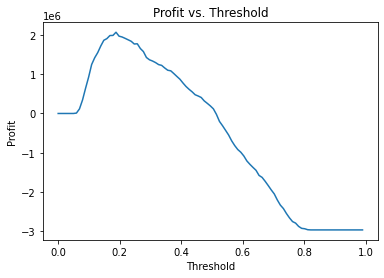

In [658]:

# Create a line plot of profits vs. thresholds
plt.plot(profits_for_t['Thresholds'], profits_for_t['Profits'])

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title('Profit vs. Threshold')

# Show the plot
plt.show()

### More Thresholds

In [684]:
more_thresholds = np.linspace(0.1830, 0.1885,101)
more_thresholds

array([0.183   , 0.183055, 0.18311 , 0.183165, 0.18322 , 0.183275,
       0.18333 , 0.183385, 0.18344 , 0.183495, 0.18355 , 0.183605,
       0.18366 , 0.183715, 0.18377 , 0.183825, 0.18388 , 0.183935,
       0.18399 , 0.184045, 0.1841  , 0.184155, 0.18421 , 0.184265,
       0.18432 , 0.184375, 0.18443 , 0.184485, 0.18454 , 0.184595,
       0.18465 , 0.184705, 0.18476 , 0.184815, 0.18487 , 0.184925,
       0.18498 , 0.185035, 0.18509 , 0.185145, 0.1852  , 0.185255,
       0.18531 , 0.185365, 0.18542 , 0.185475, 0.18553 , 0.185585,
       0.18564 , 0.185695, 0.18575 , 0.185805, 0.18586 , 0.185915,
       0.18597 , 0.186025, 0.18608 , 0.186135, 0.18619 , 0.186245,
       0.1863  , 0.186355, 0.18641 , 0.186465, 0.18652 , 0.186575,
       0.18663 , 0.186685, 0.18674 , 0.186795, 0.18685 , 0.186905,
       0.18696 , 0.187015, 0.18707 , 0.187125, 0.18718 , 0.187235,
       0.18729 , 0.187345, 0.1874  , 0.187455, 0.18751 , 0.187565,
       0.18762 , 0.187675, 0.18773 , 0.187785, 0.18784 , 0.187

In [685]:
# assigning costs to components of the CM
big_bucks = []
threshold_ls = []
TN = []
FP = []
FN = []
TP = []

for t in more_thresholds:
    binary_pred_for_t = [1 if pred >= t else 0 for pred in test_preds_act['prediction']]
    tn, fp, fn, tp = confusion_matrix(y_test, binary_pred_for_t).ravel()
    profit = (tn * 1000) + (fn * -5000)
    big_bucks.append(profit)
    threshold_ls.append(t)
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    
    #print(f't = {t}, TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}, Profit ={profit}.\n')
    
more_profits_for_t = pd.DataFrame({
    'TN': TN,
    'FP': FP,
    'FN': FN,
    'TP': TP,
    'Thresholds': threshold_ls, 
    'Profits': big_bucks
})
more_profits_for_t['Profits'].idxmax()

90

In [686]:
more_profits_for_t.iloc[80:100,]

,TN,FP,FN,TP,Thresholds,Profits
80,4906,2099,567,1428,0.187400,2071000
81,4906,2099,567,1428,0.187455,2071000
82,4906,2099,567,1428,0.187510,2071000
83,4906,2099,567,1428,0.187565,2071000
84,4909,2096,567,1428,0.187620,2074000
85,4913,2092,567,1428,0.187675,2078000
86,4914,2091,567,1428,0.187730,2079000
87,4916,2089,568,1427,0.187785,2076000
88,4916,2089,568,1427,0.187840,2076000
89,4919,2086,568,1427,0.187895,2079000


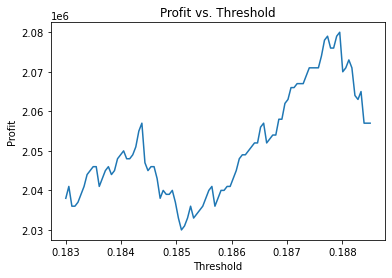

In [688]:
# Create a line plot of profits vs. thresholds
plt.plot(more_profits_for_t['Thresholds'], more_profits_for_t['Profits'])

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title('Profit vs. Threshold')

# Show the plot
plt.show()

In [80]:
# THreshold selected 0.187950
# Test AUC recieved on submissions 0.800112
# Profit recieved on submissions 2680000